In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


100%|██████████| 360/360 [00:11<00:00, 31.48it/s] 


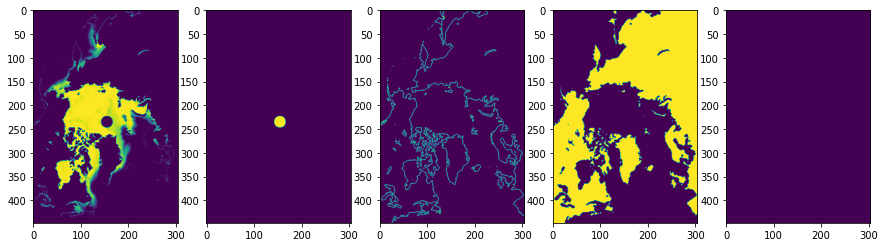

In [3]:

path = '/content/drive/MyDrive/해빙/data_v2/'
train_csv = pd.read_csv(path+'train_v2.csv') 
train_csv.head()
train_path = sorted(glob(path+'train_data_v2/*.npy'))
train_path = train_path[-30*12:]
train = []
for p in tqdm(train_path):
    train.append(np.load(p))
train = np.array(train)
train.shape

plt.figure(figsize=(15,10))
plt.subplot(151)
plt.imshow(train[0,:,:,0])
plt.subplot(152)
plt.imshow(train[0,:,:,1])
plt.subplot(153)
plt.imshow(train[0,:,:,2])
plt.subplot(154)
plt.imshow(train[0,:,:,3])
plt.subplot(155)
plt.imshow(train[0,:,:,4])


In [4]:
train_csv.describe()


,month,file_nm
count,494,494
unique,494,494
top,1978-11,197811.npy
freq,1,1


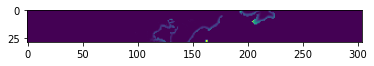

In [49]:
train_month = []
for i in range(12):
    train_month.append(train[i::12, :,:])
train_month = np.array(train_month)
train_month.shape

plt.imshow(train[0,1:30,:,0])


In [20]:
a = []
a.append(train[0::12, :,:])
a.append(
train[1::12, :,:])

a = np.array(a)
train_month.ndim

5

In [40]:
a=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
print(a[0::6])
print(a[1::6])
print(a[2::6])
print(a[3::6])
print(a[4::6])
print(a[5::6])

[1, 7, 13]
[2, 8, 14]
[3, 9, 15]
[4, 10, 16]
[5, 11, 17]
[6, 12, 18]


In [42]:
stride = 32
feature_size = 128
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                x_train_.append(x_)
                y_train_.append(y_)



AttributeError: ignored

In [55]:

stride = 32
temp = np.zeros([train_month.shape[0],
                 train_month.shape[1],
                 train_month.shape[2]+(stride-train_month.shape[2]%stride),
                 train_month.shape[3]+(stride-train_month.shape[3]%stride),
                 train_month.shape[4]], np.uint8)
temp[:, :,:train_month.shape[2], :train_month.shape[3], :] = train_month
train_month = temp
del temp
train_month.shape

(12, 30, 480, 320, 5)

In [56]:
window_size = 5
x_train = []
y_train = []

for i in range(train_month.shape[1]-window_size):
    x_train.append(train_month[:, i:i+window_size, :,:,:])
    y_train.append(train_month[:, i+window_size:i+window_size+1, :,:,:])
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train.shape, y_train.shape



((25, 12, 5, 480, 320, 5), (25, 12, 1, 480, 320, 5))

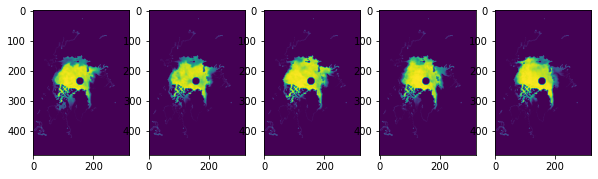

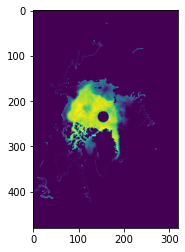

In [57]:
m = 10
plt.figure(figsize=(10,15))
for y in range(x_train.shape[2]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train[0,m-1,y,:,:,0])
plt.show()

plt.imshow(y_train[0,m-1,-1,:,:,0])


In [58]:
#stride = 32
feature_size = 128
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for m in range(12):
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
            y_ = y_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
            x_val_.append(x_)
            y_val_.append(y_)
            
x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)


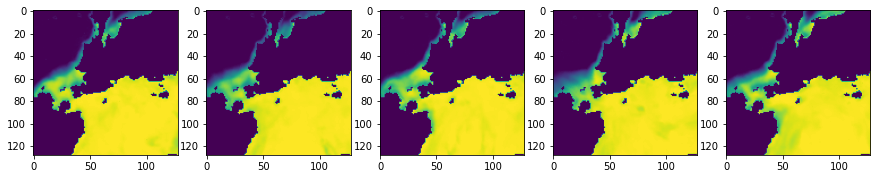

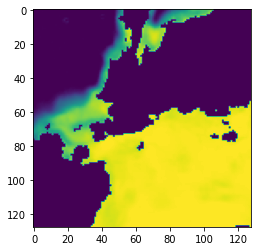

In [59]:
x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape

i = 22
plt.figure(figsize=(15,10))
for y in range(x_train_.shape[1]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train_[i,y,:,:,0])
plt.show()
plt.imshow(y_train_[i,-1,:,:,0])


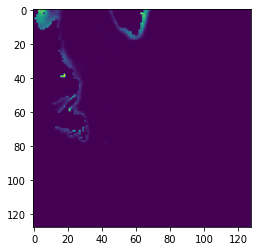

In [64]:
plt.show()

plt.imshow(y_train_[500,-1,:,:,0])


In [61]:
def train_map_func(x, y):
    x = tf.cast(x, tf.float32)/250
    y = tf.cast(y, tf.float32)
    return x, y

BATCH_SIZE = 8


train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape


(TensorShape([8, 5, 128, 128, 1]), TensorShape([8, 1, 128, 128, 1]))

In [ ]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape


(TensorShape([8, 5, 128, 128, 1]), TensorShape([8, 1, 128, 128, 1]))

In [ ]:
with strategy.scope():
    inputs=Input((None, x_train_.shape[2], x_train_.shape[3], 1))

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(inputs)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    outputs = Conv3D(filters=1, kernel_size=3, activation='tanh', padding='same', data_format='channels_last')(convLSTM)

    model = Model(inputs, outputs)
    model.compile(loss='mae', optimizer=Adam())
    
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 128, 128,   0         
                             1)]                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 128, 128, 6  150016    
                             4)                                  
                                                                 
 batch_normalization (BatchN  (None, None, 128, 128, 6  256      
 ormalization)               4)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 128, 128, 6  295168    
                             4)                                  
                                                                 
 batch_normalization_1 (Batc  (None, None, 128, 128, 6  256  

In [ ]:
if not (os.path.isdir('models')):
    os.makedirs('models')

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = './models/convlstm_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

hist = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks_list)


Epoch 1/20
